<a href="https://colab.research.google.com/github/aleschiavo94/Convolutional-Neural-Network-for-Medical-Imaging-Analysis---Abnormality-detection-in-mammography/blob/main/Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) 

Mounted at /content/gdrive


#0.1 Load Functions

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns # Grouped bar plot
import itertools
import numpy as np
import pandas as pd 
import ast #Abstract Syntax Trees
import os 
import gc # Garbage Collector

from tensorflow.keras import backend as K # Useful to free GPU and memory
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from keras import layers, optimizers, models, regularizers, metrics
from keras.models import load_model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from keras.models import Model

from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg
from tensorflow.keras.applications.resnet import preprocess_input as preprocess_input_resnet

from sklearn.metrics import accuracy_score

import scipy
import scipy.misc
from PIL import Image
BATCH_SIZE = 20
EPOCHS = 50

base_path = "/content/gdrive/My Drive/Colab Notebooks/CIDL/DL Project"
train_img_path = os.path.join(base_path, "numpy data/train_tensor.npy")
train_label_path = os.path.join(base_path, "numpy data/train_labels.npy")
test_img_path = os.path.join(base_path, "numpy data/public_test_tensor.npy")
test_label_path = os.path.join(base_path, "numpy data/public_test_labels.npy")

MODEL_PATH = os.path.join(base_path, "models/PreTrained-Masses-Calcifications/")
PLOTS_PATH = os.path.join(base_path, "plots/Masses-Calcifications")


# to produce final model report histogram 
AUC_values = []
TPR_values = []
FPR_values = []
PRECISION_values = []
SPECIFICITY_values = []

# Load Arrays from Numpy Files
def load_training():
  train_images = np.load(train_img_path)
  train_labels = np.load(train_label_path)
  test_images = np.load(test_img_path)
  test_labels = np.load(test_label_path)

  return train_images, train_labels, test_images, test_labels

def get_model_predictions(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=False):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

    #np.where(predictions < 0.5, 0, 1)
    #predictions = np.where(predictions < 0.5, 0, 1)

  return predictions


# Remove baseline samples
def remove_baseline(tensor): 
  max_ind = int(len(tensor)/2)
  indexes = [2*i + 1 for i in range(0, max_ind)]

  return tensor[indexes]

# Interchange the dataset index
def shuffle_dataset(x, y):
  indices = tf.range(start=0, limit=tf.shape(x)[0], dtype=tf.int32)
  shuffled_indices = tf.random.shuffle(indices)

  x = tf.gather(x, shuffled_indices)
  y = tf.gather(y, shuffled_indices)

  x = x.numpy()
  y = y.numpy()

  return x, y

# split dataset into training and validation set 70-30
def split_train_val(dataset, labels):
  train_data_split = dataset[:int(0.7*len(dataset))]
  valid_data_split = dataset[int(0.7*len(dataset)):]
  train_labels_split = labels[:int(0.7*len(labels))]
  valid_labels_split = labels[int(0.7*len(labels)):]

  print(train_data_split.shape)
  print(valid_data_split.shape)
  print(train_labels_split.shape)
  print(valid_labels_split.shape)      

  return train_data_split, valid_data_split, train_labels_split, valid_labels_split



def cross_validate(k, batch_size, num_epochs, dataset, targets, verbosity, model_path):
  #10-Fold-Cross-Validation
  num_val_samples = len(dataset) // k 
  validation_accuracies = []
  validation_losses = []
  validation_precisions = []
  validation_recalls = []
  validation_aucs = []
  model = models.load_model(os.path.join(MODEL_PATH, model_path))
  for i in range(k):
    # rigen augmented data 
    
    print("processing fold #", i)
    validation_data = dataset[i * num_val_samples : (i + 1) * num_val_samples]
    validation_labels = targets[i * num_val_samples : (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [dataset[:i * num_val_samples],
        dataset[(i + 1) * num_val_samples:]], 
        axis=0)

    partial_train_targets = np.concatenate(
        [targets[:i * num_val_samples],
        targets[(i + 1) * num_val_samples:]], 
        axis=0)

    
    
    history = model.fit(train_datagen.flow(partial_train_data, 
                                          partial_train_targets,
                                          batch_size=batch_size,
                                          shuffle=False),
                        epochs=num_epochs,
                        steps_per_epoch=len(partial_train_data) // batch_size,
                        verbose=verbosity,
                        callbacks=[GarbageCollectorCallback()])
    
    val_loss, val_acc, val_prec, val_rec, val_auc= model.evaluate(valid_datagen.flow(validation_data,
                                                          validation_labels,
                                                          batch_size=batch_size,
                                                          shuffle=False),
                                       steps=len(validation_data) // batch_size,
                                       callbacks=[GarbageCollectorCallback()])
    
    validation_accuracies.append(val_acc)
    validation_losses.append(val_loss)
    validation_precisions.append(val_prec)
    validation_recalls.append(val_rec)
    validation_aucs.append(val_auc)

    ## ADDED TO TRY AND REDUCE RAM USAGE DURING CROSS VALIDATE
    del partial_train_targets
    del partial_train_data
    del validation_data
    del validation_labels
    del history
    
  return validation_accuracies, validation_losses, validation_precisions, validation_recalls, validation_aucs


def global_contrast_normalization(X):
    X_average = np.mean(X)
    #print('Mean: ', X_average)
    X = X - X_average
    return X

# Visualization Confusion Matrix
def plot_confusion_matrix(model,
                          classes,
                          dataset, 
                          labels,
                          test_datagen,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    Y_pred = model.predict(test_datagen.flow(dataset,
                                            labels,
                                            batch_size=21,
                                            shuffle=False),
                          steps=len(dataset) // BATCH_SIZE)

    np.where(Y_pred < 0.5, 0, 1)
    y_pred = np.where(Y_pred < 0.5, 0, 1)

    print('Confusion Matrix')
    cm = confusion_matrix(labels, y_pred)

    #print(cm)
    #print('Classification Report')
    print(classification_report(labels, y_pred))


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return plt


def plot_loss(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  return plt

# Visualization Data Histogram
def plot_acc(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure()
  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  return plt

# Visualization Data Histogram
def plot(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  return plt

# Visualization Detail Metric
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  plt.figure(figsize=(12,10))

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

  return plt


def plot_AUC(model, dataset, labels):
  y_pred_keras = get_model_predictions(model, dataset, labels, len(dataset))
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, y_pred_keras)
  #thresholds_keras = np.linspace(0,1,num=100)
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='CNN (area = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  #plt.show()

  return auc_keras, plt

def plot_AUC2(model, dataset, labels):
  y_pred_keras = get_model_predictions(model, dataset, labels, len(dataset))
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, y_pred_keras)
  #thresholds_keras = np.linspace(0,1,num=100)
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='CNN (area = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()


# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
      gc.collect()



print("Done")



Done


##Labels Mapping - Masses vs Calcifications

In [ ]:
# Masses and Calcifications 
def labels_mapping(labels):
  labels_local = np.zeros(shape=labels.shape, dtype="float32")
  idx = 0
  for label in labels:
    # Masses
    if label == 1 or label == 2:
      labels_local[idx] = 0
    # Calcifications
    else:
      labels_local[idx] = 1
    idx += 1

  return labels_local



## Labels Mapping - Benign vs Malign

In [ ]:
# Benign and Malign 
def labels_mapping(labels):
  labels_local = np.zeros(shape=labels.shape, dtype="float32")
  idx = 0
  for label in labels:
    # Benign
    if label == 1 or label == 3:
      labels_local[idx] = 0
    # Malign
    else:
      labels_local[idx] = 1
    idx += 1

  return labels_local


# 0.2 Set Metrics and Global Variables

In [ ]:
INPUT_SHAPE = (150, 150, 3)
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 20


METRICS = [
      metrics.BinaryAccuracy(name='acc'),
      #metrics.Precision(name='precision'),
      #metrics.Recall(name='recall'),
      #metrics.AUC(name='auc'),
      # metrics.TruePositives(name='tp'),
      # metrics.FalsePositives(name='fp'),
      # metrics.TrueNegatives(name='tn'),
      # metrics.FalseNegatives(name='fn'),     
]

es = tf.keras.callbacks.EarlyStopping(
     monitor='val_loss', patience=20, verbose=0,
     mode='auto', restore_best_weights=True
)

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
      gc.collect()

print("Done")

Done


#Load Test DataSet

In [ ]:
train_images, train_labels, test_images, test_labels = load_training()

test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)
test_labels = labels_mapping(test_labels)
test_images, test_labels = shuffle_dataset(test_images, test_labels)
test_images = test_images.reshape(test_images.shape + (1,))

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)


print(test_images.shape)

test_datagen_incp = ImageDataGenerator(rescale=1./65535) 

test_datagen_vgg = ImageDataGenerator(rescale=1./65535, preprocessing_function=preprocess_input_vgg) 

test_datagen_resnet = ImageDataGenerator(rescale=1./65535, preprocessing_function=preprocess_input_resnet) 

(336, 150, 150, 3)


# Ensemble with Majority Vote

##Ensemble Masses vs Calcifications 

In [ ]:
# vgg1 = models.load_model(MODEL_PATH + '/Vgg/vgg__globalAvgPool_dense_256x1_last_3_blocks_trainable.h5')             # 89.69   % accuracy
# vgg2 = models.load_model(MODEL_PATH + '/Vgg/vgg__globalAvgPool_dense_256x3_last_3_blocks_trainable.h5')             # not used
# resnet1 = models.load_model(MODEL_PATH + '/ResNet/resNet_dense_256x1_last_block_trainable.h5')                      # 90      % accuracy
# resnet2 = models.load_model(MODEL_PATH + '/ResNet/ResNet_flatten_dense_256x3_last_3_blocks_trainable.h5')           # 90      % accuracy
# inception1 = models.load_model(MODEL_PATH + '/Inception/Inception_flatten_dense_256_all_trainable.h5')              # 89.38   % accuracy
# inception2 = models.load_model(MODEL_PATH + '/Inception/Inception_flatten_dense_256x3_last_3_blocks_trainable.h5')  # 89.06   % accuracy

In [ ]:
test_images_np = np.array(test_images)
test_images_np = test_images_np/65535

In [ ]:
y_pred_list = []
MODEL_PATH = os.path.join(base_path, "models/PreTrained-Masses-Calcifications/")
model_list = []
model_list.append(models.load_model(MODEL_PATH + '/Vgg/vgg__globalAvgPool_dense_256x1_last_3_blocks_trainable.h5'))
#model_list.append(models.load_model(MODEL_PATH + '/Vgg/vgg__globalAvgPool_dense_256x3_last_3_blocks_trainable.h5'))
model_list.append(models.load_model(MODEL_PATH + '/ResNet/resNet_dense_256x1_last_block_trainable.h5'))
model_list.append(models.load_model(MODEL_PATH + '/ResNet/ResNet_flatten_dense_256x3_last_3_blocks_trainable.h5'))
model_list.append(models.load_model(MODEL_PATH + '/Inception/Inception_flatten_dense_256_all_trainable.h5'))
model_list.append(models.load_model(MODEL_PATH + '/Inception/Inception_flatten_dense_256x3_last_3_blocks_trainable.h5')) ## until here, 91,667%

model_list.append(models.load_model(MODEL_PATH + '/ResNet/ResNet_flatten_dense_256_all_trainable.h5'))
model_list.append(models.load_model(MODEL_PATH + '/ResNet/resNet_dense_256x1_last_2_blocks_trainable.h5'))
model_list.append(models.load_model(MODEL_PATH + '/Vgg/vgg_flatten_dense_256x3_last_3_blocks_trainable.h5'))
model_list.append(models.load_model(MODEL_PATH + '/Vgg/vgg_flatten_dense_256x3_last_2_blocks_trainable.h5'))
model_list.append(models.load_model(MODEL_PATH + '/ResNet/ResNet_flatten_dense_256x5_last_3_blocks_trainable.h5'))
model_list.append(models.load_model(MODEL_PATH + '/Inception/Inception_Flatten_dense_256x1_last_3_blocks_trainable.h5'))  ##until here, 92,26%


#Commented because adding these lower the Overall Test Accuracy
# model_list.append(models.load_model(MODEL_PATH + '/ResNet/ResNet_flatten_dense_256x5_last_2_blocks_trainable.h5'))
# model_list.append(models.load_model(MODEL_PATH + '/Vgg/vgg_dense_256x1_last_2_blocks_trainable.h5'))
# model_list.append(models.load_model(MODEL_PATH + '/Inception/Inception_dense_256x1_last_2_blocks_trainable.h5'))
# model_list.append(models.load_model(MODEL_PATH + '/Vgg/vgg_finetune_dense_256_and_last_ConvBlock.h5'))  ## until here, 91.37%


for model in model_list:
  y_pred = model.predict(test_images_np)
  y_pred_np = np.array(y_pred)
  y_pred_np = (y_pred_np > 0.5).astype(int)
  y_pred_list.append(y_pred_np)
  


In [ ]:
result_voting = np.zeros(test_labels.shape)
tmp_list = []
for predict in y_pred_list:
  predict = np.where((predict<0.5), -1, 1) 
  tmp_list.append(predict)

result = np.array(tmp_list)
result = result.sum(axis=0)

result_voting = (result > 0).astype(int)

In [ ]:
result = accuracy_score(test_labels, result_voting)
print(result)

0.9226190476190477


Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93       179
         1.0       0.91      0.93      0.92       157

    accuracy                           0.92       336
   macro avg       0.92      0.92      0.92       336
weighted avg       0.92      0.92      0.92       336



Text(0.5, -29.27044545606752, 'Predicted label')

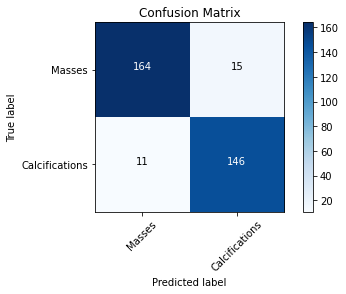

In [ ]:
print('Confusion Matrix')
cm = confusion_matrix(test_labels, result_voting)

#print(cm)
#print('Classification Report')
print(classification_report(test_labels, result_voting)) ## good

title = 'Confusion Matrix'
classes = ['Masses', 'Calcifications']
cmap=plt.cm.Blues
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

#print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

## Ensemble Benign vs Malign

In [ ]:
test_images_np = np.array(test_images)
test_images_np = test_images_np/65535

#best_1 = 69.38%
#best_2 = 71.25%
#best_3 = 68.43%
#best_4 = 72.18%
#best_5 = 66.56%


y_pred_list = []
MODEL_PATH = os.path.join(base_path, "models/PreTrained-Benign-Malign/")
model_list = []
model_list.append(models.load_model(MODEL_PATH + '/BEST_1_ENSEMBLE.h5'))
model_list.append(models.load_model(MODEL_PATH + '/BEST_2_ENSEMBLE.h5'))
model_list.append(models.load_model(MODEL_PATH + '/BEST_3_ENSEMBLE.h5'))
model_list.append(models.load_model(MODEL_PATH + '/BEST_4_ENSEMBLE.h5'))
model_list.append(models.load_model(MODEL_PATH + '/BEST_5_ENSEMBLE.h5')) 

In [ ]:
y_pred_list = []
for model in model_list:
  y_pred = model.predict(test_images_np)
  y_pred_np = np.array(y_pred)
  y_pred_np = (y_pred_np > 0.5).astype(int)
  y_pred_list.append(y_pred_np)

In [ ]:
result_voting = np.zeros(test_labels.shape)
tmp_list = []
for predict in y_pred_list:
  predict = np.where((predict<0.5), -1, 1) 
  tmp_list.append(predict)

result = np.array(tmp_list)
result = result.sum(axis=0)


result_voting = (result > 0).astype(int)
result = accuracy_score(test_labels, result_voting)
print(result)

0.6904761904761905


Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.79      0.71      0.75       219
         1.0       0.55      0.66      0.60       117

    accuracy                           0.69       336
   macro avg       0.67      0.68      0.67       336
weighted avg       0.71      0.69      0.70       336



Text(0.5, -6.819805153394636, 'Predicted label')

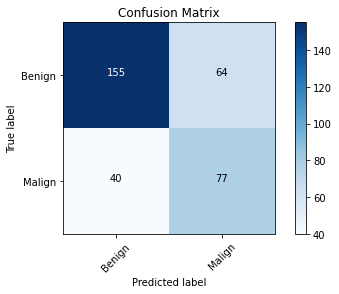

In [ ]:
print('Confusion Matrix')
cm = confusion_matrix(test_labels, result_voting)

#print(cm)
#print('Classification Report')
print(classification_report(test_labels, result_voting)) ## good

title = 'Confusion Matrix'
classes = ['Benign', 'Malign']
cmap=plt.cm.Blues
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

#print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Private Test Set Submission.csv file Generation

In [ ]:


MODEL_PATH = os.path.join(base_path, "models/PreTrained-Benign-Malign/")
#ResNet 3x drop Dense , last 3 blocks
model = models.load_model(MODEL_PATH + '/BEST_4_ENSEMBLE.h5')


In [ ]:
test_private_path = os.path.join(base_path, "numpy data/private_test_tensor.npy")


test_images = np.load(test_img_path)

test_images = test_images.reshape(test_images.shape + (1,))

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)
  
test_images = test_images/65535
print(test_images.shape)

(672, 150, 150, 3)


In [ ]:
y_pred = model.predict(test_images)
y_pred_np = (y_pred > 0.5).astype(int)
print(y_pred_np)

In [ ]:
file_path = os.path.join(base_path, "/Submission.csv")
f = open(base_path + '/Submission.csv','w')

for elem in y_pred_np:
  f.write(str(elem[0])+'\n')
## Python will convert \n to os.linesep
f.close()